In [1]:
from qiskit.circuit.library import XGate, YGate, ZGate, UnitaryGate
from qiskit.quantum_info import Operator
import numpy as np
import random 

class GeneratePopulation:

    """
    Generates a population of pulse gate sequences using gates in `HIGH_FIDELITY_GATES`. 
    Single-qubit gates were chosen because of their high-fidelity. 

    The pulse sequences are generated via building arbitrary subsequences using 
    gates defined in `basis_gates`. These subsequences all tensor to the identity 
    matrix, up to an overall phase. 


    Methods
    -------

    def generate_individuals(self):
        generates one randomized sequence of pulse-gates using the provided class 
        parameterso build a single individual.
    
    def infant_product(self, infant):
        calculates the net unitary matrix from a list (`infant`) of matrices. 

    def is_identity(self, matrix): 
        checks whether matrix is quantum mechanically equivalent to an identity
        matrix (up to an overall global phase). 

    def population(self): 
        generates a pulse-gate population of randomized individuals of size 
        `num_individuals`. 

    Example
    -------
    class_ = GeneratePopulation(basis_gates=[XGate(), YGate(), ZGate()], 
                                num_individuals = 100, 
                                length_range = [4, 20],
                                max_gate_reps = 4, 
                                gate_names = ['X', 'Y', 'Z'],
                                verbose = True)

    class_.population()

    - Generates a population of 100 individuals. 
    - Each individual is made up of Pauli X, Y, Z gates. 
    - The gate depth (# gates) within an individual is between 4 and 20. 
    - A subsequence of an individual has at most 4 repetitions of the same gate. 
    
    """

    def __init__(self, basis_gates, num_individuals, max_gate_reps, 
                 approx_length = None, length_range = None, 
                 basis_names = None, verbose = True): 
        """
        Parameters
        ----------

        basis_gates: array-like
            stores the gates to use for generating randomized pulse gate sequences.

        num_individuals: int
            number of individuals in a population to generate.

        max_gate_reps: int 
            the maximum number of repetitions of a basis gate within a subsequence.

        OPTIONAL
        --------
        approx_length: int
            if defined, all individuals / pulse sequences in a population will have
            roughly the same gate depth = approx_length.

        length_range: [int_min, int_max] 
            if defind, all individuals / pulse sequences will be of randomized 
            depth between int_min and int_max.

        *** either approx_length or length_range must be defined ***

        basis_names : [string_1, string_2, ..., string_len(basis_states)]
            names of the operators in basis_states

        verbose: bool 
            to print out additional information when running

        """

        self.basis_gates = basis_gates
        self.num_individuals = num_individuals
        self.max_gate_reps = max_gate_reps
        self.approx_length = approx_length
        self.length_range = length_range
        self.basis_names =  basis_names
        self.verbose = verbose
        self.count = 0

    def generate_individual(self):

        """
        Generates randomized pulse-gate individual/sequence 

        Returns: 
        --------
        individual: list 
            list of matrices (numpy arrays) that make up the individual
        individual_name: 
            if self.basis_names provided, returns a simplified version of 
            the individual sequence using the names of each gate. 
            (i.e. ['X', 'Y', 'X', 'Y'] for XY4). Otherwise []. 

        """ 

        individual = []
        fixed_length = False

        if self.approx_length: 
            fixed_length = True
        elif self.length_range: 
            fixed_length = False
        else: 
            raise Exception('Either `self.approx_length` or `self.length_range` must be defined')

        if fixed_length: 
            while len(individual) < self.approx_length: 
                infant = [] 
                num_reps = random.choice(range(2, self.max_gate_reps, 2))
                basis_idxs = [random.randint(0, len(self.basis_gates) - 1) for j in range(num_reps)]

                for idx in basis_idxs: 
                    infant.append(self.basis_gates[idx])

                if self.is_identity(self.infant_product(infant)):
                    individual.extend(infant)
        else: 
            length = random.randint(self.length_range[0], self.length_range[1])
            while len(individual) < length: 
                infant = [] 
                num_reps = random.choice(range(2, self.max_gate_reps, 2))
                basis_idxs = [random.randint(0, len(self.basis_gates) - 1) for j in range(num_reps)]

                for idx in basis_idxs: 
                    infant.append(self.basis_gates[idx])

                if self.is_identity(self.infant_product(infant)):
                    individual.extend(infant)

        individual_name = []
        if self.basis_names: 
            for i in individual: 
                for j in range(len(self.basis_gates)): 
                    if np.allclose(i, self.basis_gates[j], atol = 1e-6): 
                      individual_name.append(self.basis_names[j])

            if self.verbose: 
                print(f"Individual {self.count+1}")
                print(f" {str(individual_name):>13}")
                print("")

        elif self.verbose: 
            print(f"Individual {self.count} generated.")

        return individual, individual_name

    def infant_product(self, infant): 

        # Calculates net unitary matrix from infant subsequence

        if not infant: 
            raise Exception('Infant was never born')

        return np.linalg.multi_dot(infant)

    def is_identity(self, matrix, tolerance = 1e-6): 

        # checks whether net unitary matrix from infant subsequence
        # is equivalent to identity matrix (up to overall global phase)

        identity_matrix = np.eye(matrix.shape[0])

        if matrix[0, 0] == 0: 
            return False

        normalized = matrix / matrix[0, 0]

        return np.allclose(normalized, identity_matrix, atol=tolerance)

    def population(self): 
        
        # Generates population of length `num_individuals`
        # Each individual pseudo-randomized based on class parameters.

        population  = []

        for i in range(self.num_individuals): 
            individual, _ = self.generate_individual()
            individual = self.individual_to_dd(individual)

            if individual not in population: 
                population.append(individual)

            self.count += 1

        if self.verbose:
            print("")
            print("Population generated")
            print("")

        return population

    def individual_to_dd(self, individual):
        dd_individual = []

        for gate_idx in range(len(individual)): 
            for basis_gate_idx in range(len(self.basis_gates)): 
                if np.allclose(Operator(individual[gate_idx]), self.basis_gates[basis_gate_idx], atol = 1e-6):
                    unitary_gate = UnitaryGate(self.basis_gates[basis_gate_idx])
                    unitary_gate.name = self.basis_names[basis_gate_idx]
                    dd_individual.append(unitary_gate)
        return dd_individual






class_ = GeneratePopulation(basis_gates=[XGate(), YGate(), ZGate()], 
                            num_individuals = 8, 
                            length_range = [4, 6],
                            max_gate_reps = 6, 
                            basis_names = ['x', 'y', 'z'],
                            verbose = True)

population = class_.population()

Individual 1
 ['z', 'z', 'z', 'y', 'y', 'z']

Individual 2
 ['y', 'y', 'z', 'z', 'z', 'z']

Individual 3
 ['x', 'x', 'x', 'x', 'y', 'y']

Individual 4
 ['x', 'x', 'z', 'z', 'z', 'y', 'y', 'z']

Individual 5
 ['y', 'y', 'x', 'y', 'y', 'x']

Individual 6
 ['x', 'x', 'z', 'z', 'y', 'y']

Individual 7
 ['z', 'z', 'x', 'x']

Individual 8
 ['z', 'y', 'y', 'z']


Population generated



---

# Structure 
---

- Input arbitrary circuit.

- Extract initial circuit gate data; input data into a preliminary `InstructionDurations()` method. 

- Insert individual dd sequence into the InstructionDurations() with a duration that exceeds the time threshold. 

- Convert circuit into schedule using `PassManager` class with `ALAPSchedule` and the proper `DynamicalDecoupling(durations, dd_sequence)`.

- Extract time intervals between gates acting on a specific qubit using the `delay`  gate information. 

- Use that information to generate new, optimized symmetric dd sequences that evenly (or using some oscillating function like Uhrig) divides the dd pulses within the alotted interval timespace. 


- Regenerate scheduled circuit and display


In [83]:
from qiskit.circuit.library import TwoLocal, EfficientSU2
from qiskit.circuit import QuantumCircuit, Instruction, QuantumRegister, ClassicalRegister
from qiskit.transpiler import PassManager, InstructionDurations
from qiskit.transpiler.passes import ALAPSchedule, DynamicalDecoupling
from qiskit.visualization import timeline_drawer
from qiskit.providers.fake_provider import *

def draw(circuit): 
    from qiskit import transpile

    scheduled = transpile(
        circuit, 
        optimization_level = 0, 
        instruction_durations = InstructionDurations(), 
        scheduling_method = 'alap'
    )

    return display(timeline_drawer(scheduled))

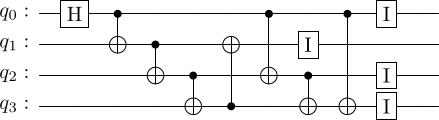

In [3]:
from qiskit.circuit import QuantumCircuit

tc = QuantumCircuit(4)
tc.h(0)
tc.cx(0, 1)
tc.cx(1, 2)
tc.cx(2, 3)
tc.cx(3, 1)
tc.cx(0, 2)
tc.cx(2, 3)
tc.cx(0, 3)
tc.id(range(0, tc.num_qubits))

# random input test circuit with sufficient qubit idle time 
tc.draw('latex')

In [65]:
def generate_gate_timing(circuit, verbose = False):
    gate_timings = []

    for instruction in circuit.data:
        inst = instruction.operation
        qubits = [tc.find_bit(qubit).index for qubit in instruction.qubits]  
        
        duration = instruction.operation.duration if hasattr(inst, 'duration') else None

        gate_timings.append({
            'gate': inst.name,
            'qubits': qubits,
            'duration': duration,
        })

    if verbose: 
        for timing in gate_timings:
            print('{:<4} | {:<6} | {}'.format('Gate', 'Qubit', 'Duration'))
            print('{:<4} | {:<6} | {}'.format(timing['gate'],
                                              str(timing['qubits']),
                                              timing['duration']))
        
    return gate_timings

def gate_timing_to_duration(gate_timings): 
    durations_list = []
    for gate in gate_timings: 
        durations_list.append((gate['gate'], gate['qubits'], 100))

    return durations_list

durations_list = gate_timing_to_duration(generate_gate_timing(tc, True))

Gate | Qubit  | Duration
h    | [0]    | None
Gate | Qubit  | Duration
cx   | [0, 1] | None
Gate | Qubit  | Duration
cx   | [1, 2] | None
Gate | Qubit  | Duration
cx   | [2, 3] | None
Gate | Qubit  | Duration
cx   | [3, 1] | None
Gate | Qubit  | Duration
cx   | [0, 2] | None
Gate | Qubit  | Duration
cx   | [2, 3] | None
Gate | Qubit  | Duration
cx   | [0, 3] | None
Gate | Qubit  | Duration
id   | [0]    | None
Gate | Qubit  | Duration
id   | [1]    | None
Gate | Qubit  | Duration
id   | [2]    | None
Gate | Qubit  | Duration
id   | [3]    | None


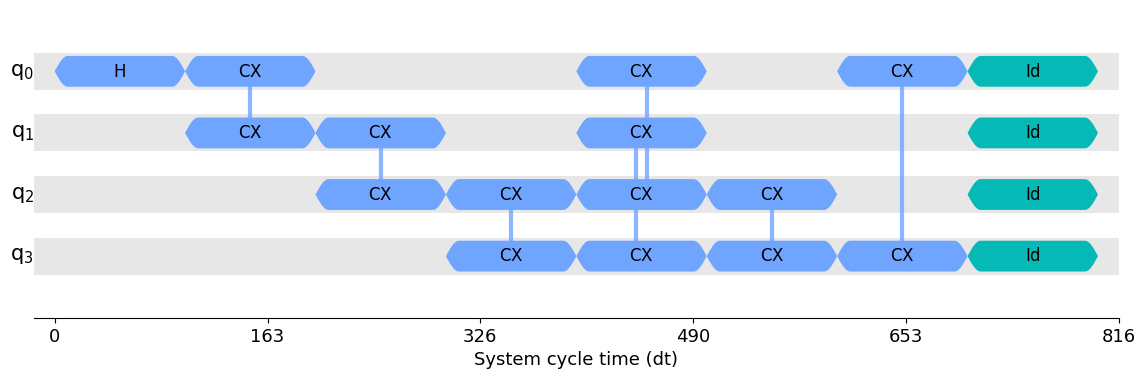

In [66]:
individual = population[0]

for unitary_gate in individual: 
    if ((unitary_gate.name, None, 1000) not in durations_list):
        durations_list.append((unitary_gate.name, None, 1000))

durations = InstructionDurations(
    durations_list
)

pm = PassManager(
    [
        ALAPSchedule(durations), 
        DynamicalDecoupling(durations, individual)
    ]
)

tc_dd = pm.run(tc)
draw(tc_dd)


Time intervals between gates for qubit 0:
[{'between': ('cx', 'cx'), 'interval': 200}, {'between': ('cx', 'cx'), 'interval': 100}]

Time intervals between gates for qubit 1:
[{'between': ('cx', 'cx'), 'interval': 100}, {'between': ('cx', 'id'), 'interval': 200}]

Time intervals between gates for qubit 2:
[{'between': ('cx', 'id'), 'interval': 100}]

Time intervals between gates for qubit 3:
[]


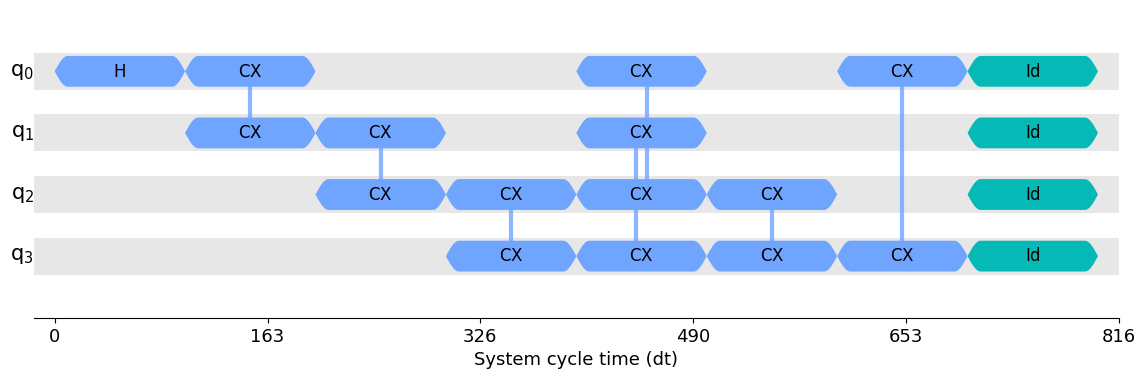

In [67]:
def calculate_intervals_with_delays(gate_timings, qubit):
    timings = [t for t in gate_timings if qubit in t['qubits']]
    intervals = []

    i = 0
    while i < len(timings) - 1:
        curr_gate = timings[i]
        next_gate = timings[i + 1]

        if next_gate['gate'] == 'delay' and qubit in next_gate['qubits']:
            delay_duration = next_gate['duration']

            if i + 2 < len(timings):
                next_gate_after_delay = timings[i + 2]
                intervals.append({
                    'between': (curr_gate['gate'], next_gate_after_delay['gate']),
                    'interval': delay_duration
                })
                i += 2  
            else:
                break  
        else:
            i += 1

    return intervals

intervals = []
for qubit_idx in range(tc_dd.num_qubits): 
    qubit_intervals = calculate_intervals_with_delays(generate_gate_timing(tc_dd), qubit_idx)
    intervals.append(qubit_intervals)
    print(f"\nTime intervals between gates for qubit {qubit_idx}:")
    print(qubit_intervals)

draw(tc_dd)

In [68]:
durations_list

[('h', [0], 100, None, 'dt'),
 ('cx', [0, 1], 100, None, 'dt'),
 ('cx', [1, 2], 100, None, 'dt'),
 ('cx', [2, 3], 100, None, 'dt'),
 ('cx', [3, 1], 100, None, 'dt'),
 ('cx', [0, 2], 100, None, 'dt'),
 ('cx', [2, 3], 100, None, 'dt'),
 ('cx', [0, 3], 100, None, 'dt'),
 ('id', [0], 100, None, 'dt'),
 ('id', [1], 100, None, 'dt'),
 ('id', [2], 100, None, 'dt'),
 ('id', [3], 100, None, 'dt'),
 ('z', None, 1000, None, 'dt'),
 ('y', None, 1000, None, 'dt')]

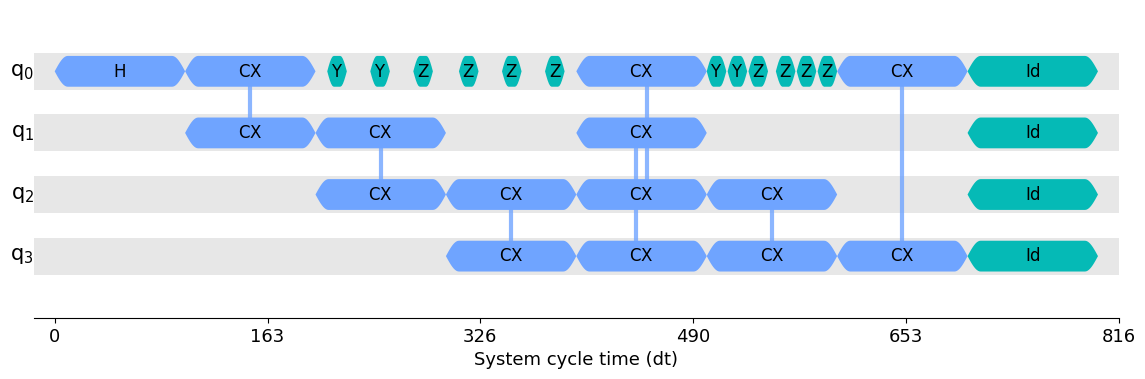

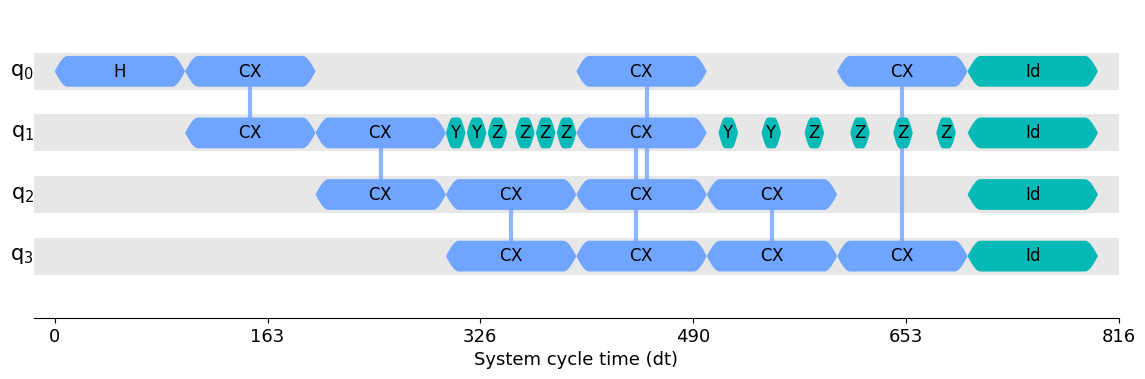

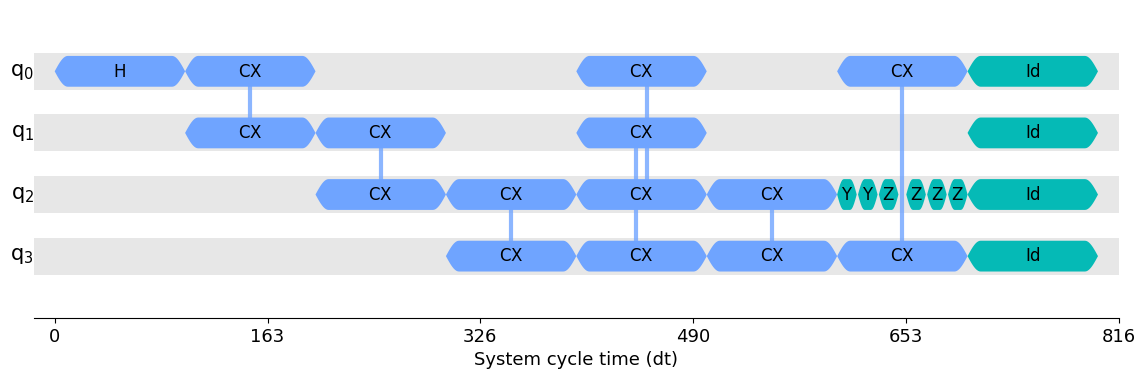

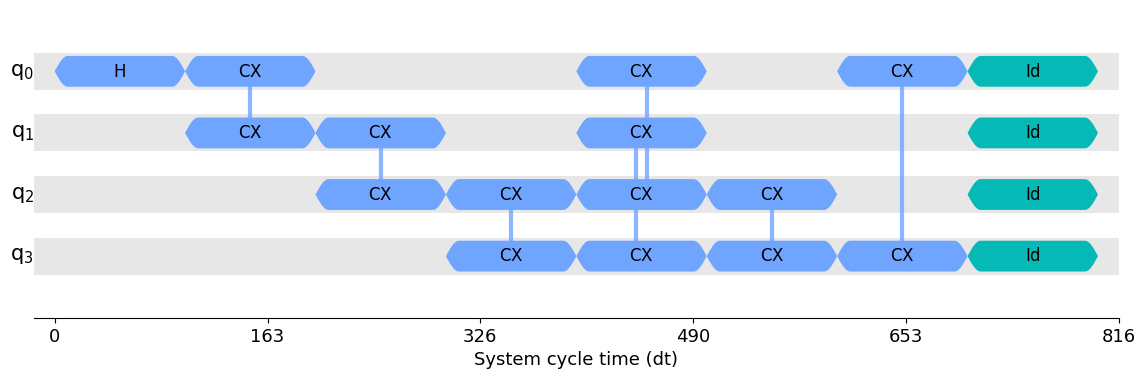

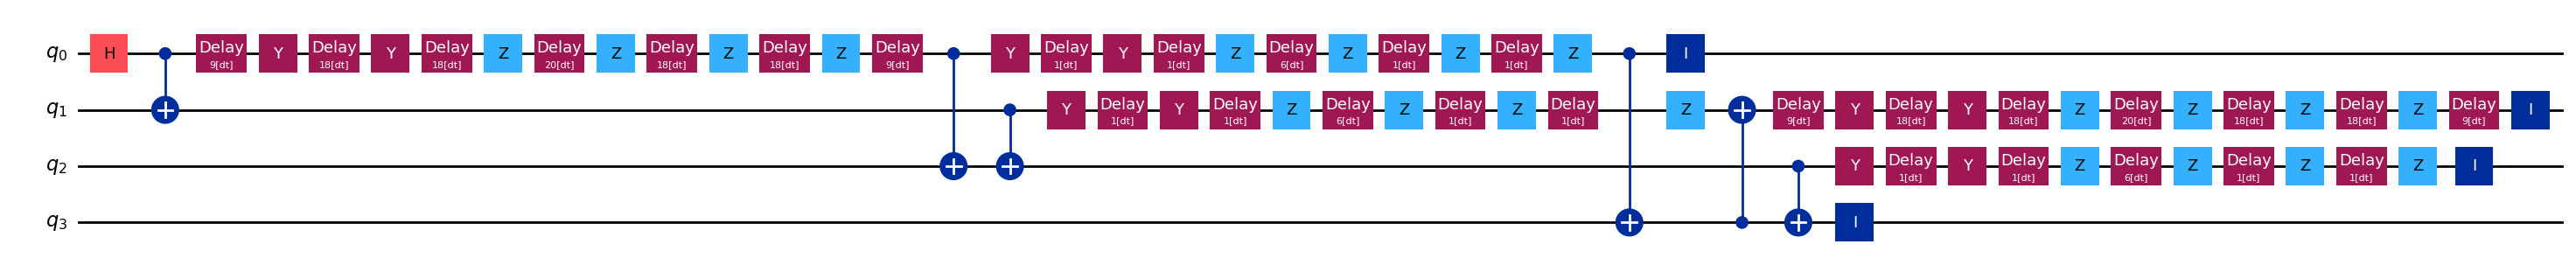

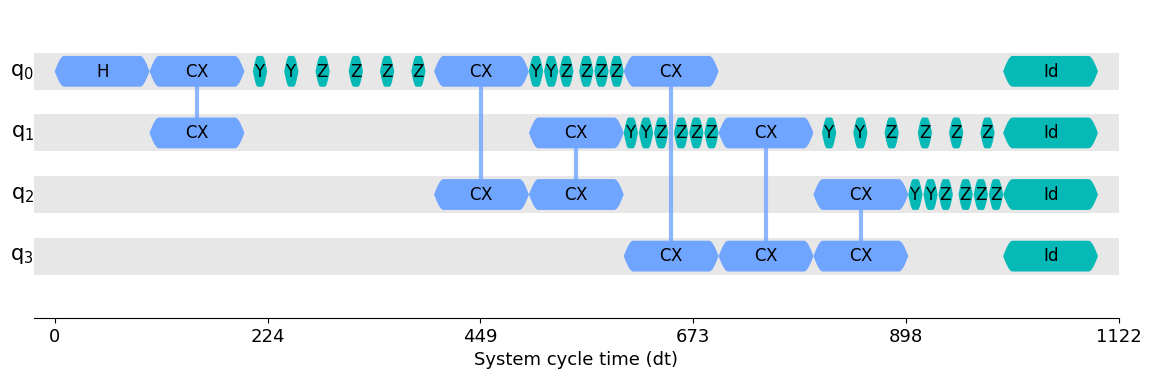

In [102]:
individual = population[1]
durations_list = gate_timing_to_duration(generate_gate_timing(tc, False))

from qiskit_ibm_runtime.fake_provider import FakeVigo

def compose_circ(circuit, duration, individual): 

    def extract_wire_operations(circuit, wire_idx):
        wire_ops = []
        for gate, qargs, cargs in circuit.data:
            if any(qarg == circuit.qubits[wire_idx] for qarg in qargs):  
                wire_ops.append((gate, qargs, cargs))
        return wire_ops

    intervals = []
    for qubit_idx in range(circuit.num_qubits): 
        qubit_intervals = calculate_intervals_with_delays(generate_gate_timing(circuit), qubit_idx)
        intervals.append(qubit_intervals)

    circuits = []
    for i in range(circuit.num_qubits): 
        dd_durations = []
        for j in range(len(individual)): 
            padding = 0
            if len(intervals[i]) == 1:
                padding = intervals[i][0]['interval']
            if len(intervals[i]) >= 2:
                padding = min(k['interval'] for k in intervals[i])
            pulse_duration = int(np.min(padding) / len(individual) - 1)
            pulse = (individual[j].name, None, pulse_duration)
            if pulse not in dd_durations:
                dd_durations.append(pulse)

        dd_qubit_durations = duration.copy()
        dd_qubit_durations.extend(dd_durations)

        durations = InstructionDurations(
            dd_qubit_durations
        )

        pm = PassManager(
            [
                
                ALAPSchedule(durations),
                DynamicalDecoupling(durations, individual, qubits = [i]),
            ]
        )
        circ_dd = pm.run(circuit)
        circuits.append(circ_dd)
    
    for i in circuits: 
        draw(i)

    qc = QuantumCircuit(QuantumRegister(circuit.num_qubits, 'q'))
    multi_qubit_gates = []
    for i in range(qc.num_qubits): 
        for gate, qargs, cargs in extract_wire_operations(circuits[i], i):
            gate_idxs = [qc.find_bit(qarg)[0] for qarg in qargs]
            if len(gate_idxs) > 1 and gate_idxs not in multi_qubit_gates:
                multi_qubit_gates.append(gate_idxs)
                qc.append(gate, qargs, cargs)
            if len(gate_idxs) == 1:
                valid = True 
                if gate.name == 'delay' and gate.duration >= 100: 
                    valid = False
                if valid: 
                    qc.append(gate, qargs, cargs)

    #qc.measure_all()
    display(qc.draw('mpl', fold = -1, idle_wires= False))

    draw(qc)


   

    return qc


qc = compose_circ(circuit = tc_dd, duration = durations_list, individual=individual)

In [41]:
durations_list

[('h', [0], 50, None, 'dt'),
 ('cx', [0, 1], 50, None, 'dt'),
 ('cx', [1, 2], 50, None, 'dt'),
 ('cx', [2, 3], 50, None, 'dt'),
 ('cx', [3, 1], 50, None, 'dt'),
 ('cx', [0, 2], 50, None, 'dt'),
 ('cx', [2, 3], 50, None, 'dt'),
 ('cx', [0, 3], 50, None, 'dt'),
 ('id', [0], 50, None, 'dt'),
 ('id', [1], 50, None, 'dt'),
 ('id', [2], 50, None, 'dt'),
 ('id', [3], 50, None, 'dt'),
 ('y', None, 7, None, 'dt'),
 ('z', None, 7, None, 'dt'),
 ('y', None, 7, None, 'dt'),
 ('z', None, 7, None, 'dt'),
 ('y', None, 7, None, 'dt'),
 ('z', None, 7, None, 'dt'),
 ('y', None, -1, None, 'dt'),
 ('z', None, -1, None, 'dt')]

In [30]:
base_durations

[('h', [0], 50),
 ('cx', [0, 1], 50),
 ('cx', [1, 2], 50),
 ('cx', [2, 3], 50),
 ('cx', [3, 1], 50),
 ('cx', [0, 2], 50),
 ('cx', [2, 3], 50),
 ('cx', [0, 3], 50),
 ('id', [0], 50),
 ('id', [1], 50),
 ('id', [2], 50),
 ('id', [3], 50),
 ('measure', None, 1000)]

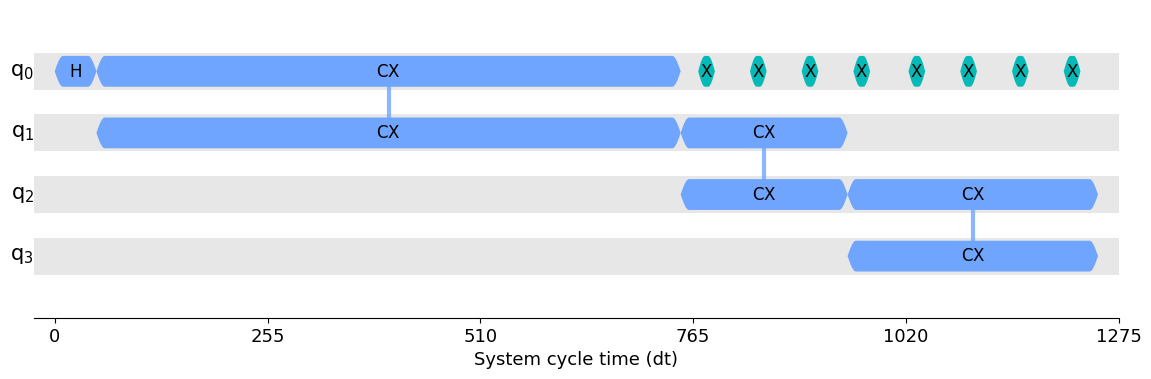

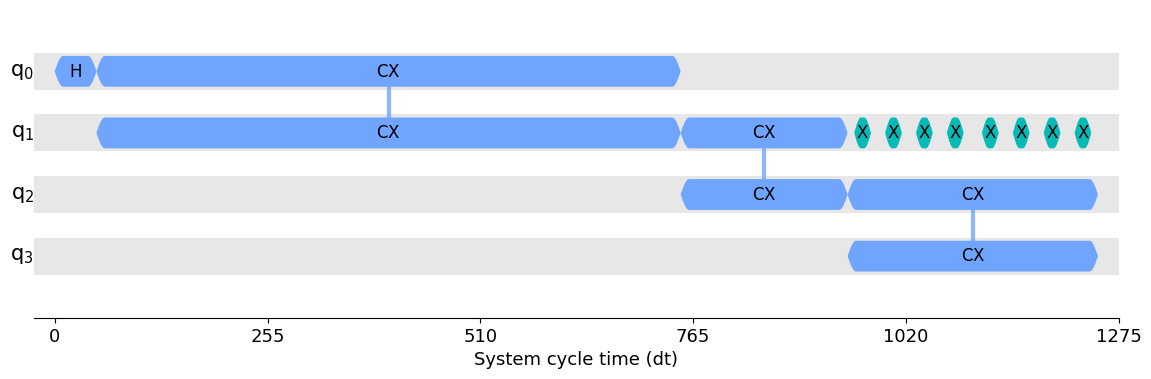

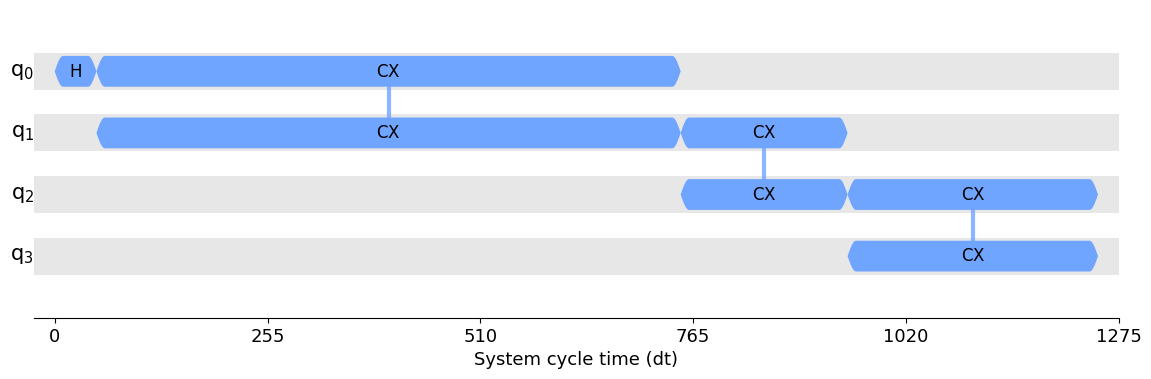

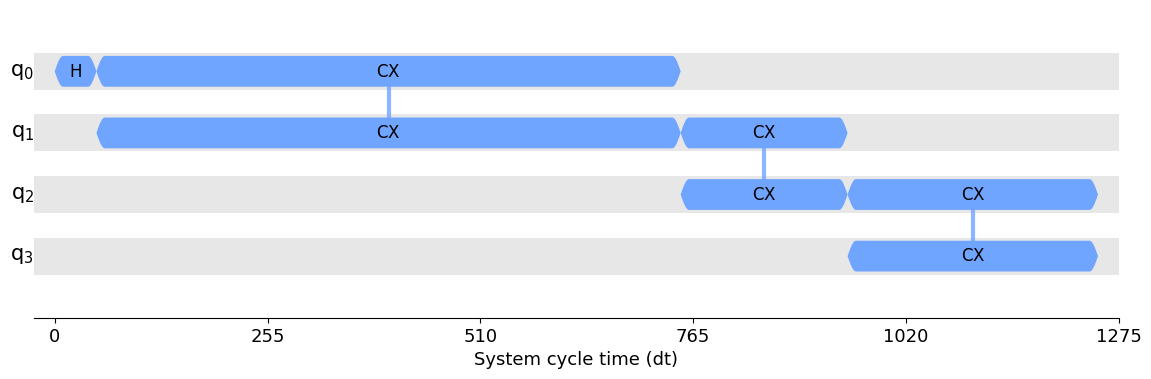

In [94]:
circ = QuantumCircuit(4)
circ.h(0)
circ.cx(0, 1)
circ.cx(1, 2)
circ.cx(2, 3)
durations = InstructionDurations(
    [("h", 0, 50), ("cx", [0, 1], 700), ("reset", None, 10),
     ("cx", [1, 2], 200), ("cx", [2, 3], 300),
     ("x", None, 20), ("measure", None, 1000)]
)

base_duration = InstructionDurations( 
    [("h", 0, 50), ("cx", [0, 1], 700), ("reset", None, 10),
     ("cx", [1, 2], 200), ("cx", [2, 3], 300), ("measure", None, 1000)]
)
 
n = 8
dd_sequence = [XGate()] * n

circuits = []
for i in range(circ.num_qubits): 
    pm = PassManager(
        [
            
            ALAPSchedule(durations),
            DynamicalDecoupling(durations, dd_sequence, qubits = [i]),
        ]
    )
    circ_dd = pm.run(circ)
    circuits.append(circ_dd)

for i in circuits:
    draw(i)

In [95]:
def extract_wire_operations(circuit, wire_idx):
    wire_ops = []
    for gate, qargs, cargs in circuit.data:
        if any(qarg == circuit.qubits[wire_idx] for qarg in qargs):  
            wire_ops.append((gate, qargs, cargs))
    return wire_ops

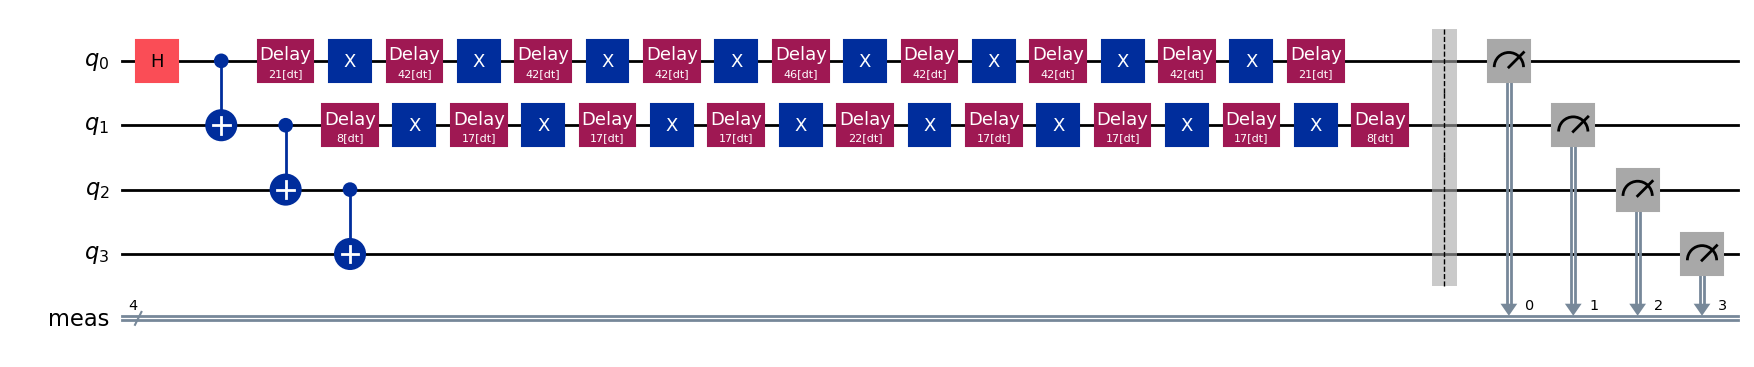

In [96]:
from qiskit import QuantumRegister, ClassicalRegister

qc = QuantumCircuit(QuantumRegister(4, 'q'))

multi_qubit_gates = []
for i in range(qc.num_qubits): 
    for gate, qargs, cargs in extract_wire_operations(circuits[i], i):
        gate_idxs = [qc.find_bit(qarg)[0] for qarg in qargs]
        if len(gate_idxs) > 1 and gate_idxs not in multi_qubit_gates:
            multi_qubit_gates.append(gate_idxs)
            qc.append(gate, qargs, cargs)
        if len(gate_idxs) == 1:
            valid = True 
            if gate.name == 'delay' and gate.duration >= 50: 
                valid = False
            if valid: 
                qc.append(gate, qargs, cargs)


qc.measure_all()
qc.draw('mpl', fold = -1, idle_wires= False)

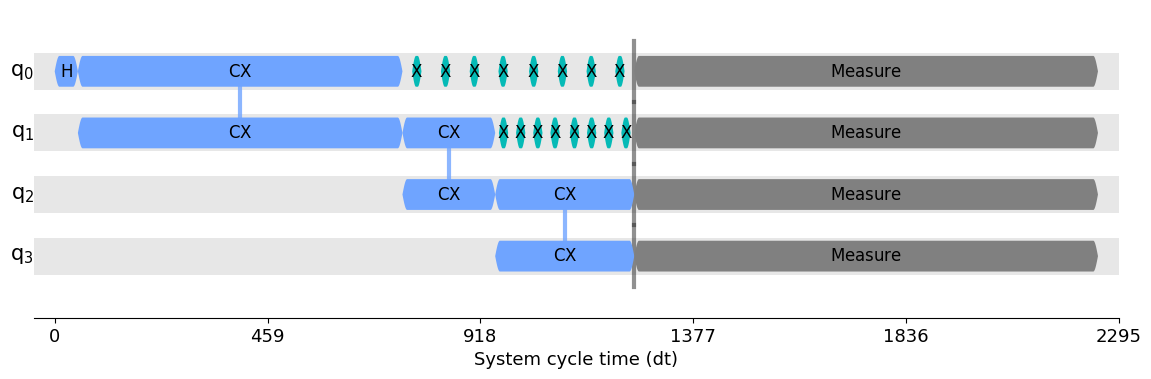

In [97]:
from qiskit import schedule, transpile
from qiskit.providers.fake_provider import GenericBackendV2

pm = PassManager(
    [
        ALAPSchedule(durations)
    ]
)
qc2 = pm.run(qc)
draw(qc2)

In [98]:
durations